# Topic Modeling and sentiment analaysis

## Topic modeling

Topic Models, in a nutshell, are a type of statistical language models used for uncovering hidden structure in a collection of texts. In a practical and more intuitively, you can think of it as a task of:

Dimensionality Reduction, where rather than representing a text T in its feature space as {Word_i: count(Word_i, T) for Word_i in Vocabulary}, you can represent it in a topic space as {Topic_i: Weight(Topic_i, T) for Topic_i in Topics}



There are several existing algorithms we can use to perform the topic modeling. The most common of it are, Latent Semantic Analysis (LSA/LSI), Probabilistic Latent Semantic Analysis (pLSA), and Latent Dirichlet Allocation (LDA)

 will go with LDA, and implement our first topic model using the sklearn implementation in python.we

# LDA Implementation

The steps used to implement LDA :
   1) Loading data
   
   2) Data cleaning
   
   
   3) Exploratory analysis
   
   
   4) Preparing data for LDA analysis
   
   
   5) LDA model training
   
   
   6) Analyzing LDA model results

# Step 1: Loading Data 

In [27]:
# Importing modules
# import warnings
# warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import STOPWORDS,WordCloud
from gensim import corpora
import pandas as pd
import statistics
import string
import os
import re

#os.chdir('..')

# Read data into papers
papers = pd.read_csv('processed_tweet_data .csv')

# Print head
papers.head()

,created_at,source,original_text,polarity,subjectivity,lang,favorite_count,retweet_count,original_author,followers_count,friends_count,possibly_sensitive,hashtags,user_mentions,place
0,Fri Jun 18 17:55:49 +0000 2021,"<a href=""http://twitter.com/download/iphone"" r...","🚨Africa is ""in the midst of a full-blown third...",0.166667,0.188889,en,548,612,ketuesriche,551,351,NaN,[],"[{'screen_name': 'TelGlobalHealth', 'name': 'T...",Mass
1,Fri Jun 18 17:55:59 +0000 2021,"<a href=""https://mobile.twitter.com"" rel=""nofo...","Dr Moeti is head of WHO in Africa, and one of ...",0.133333,0.455556,en,195,92,Grid1949,66,92,NaN,[],"[{'screen_name': 'globalhlthtwit', 'name': 'An...","Edinburgh, Scotland"
2,Fri Jun 18 17:56:07 +0000 2021,"<a href=""http://twitter.com/download/iphone"" r...",Thank you @research2note for creating this ama...,0.316667,0.483333,en,2,1,LeeTomlinson8,1195,1176,NaN,"[{'text': 'red4research', 'indices': [103, 116]}]","[{'screen_name': 'NHSRDForum', 'name': 'NHS R&...",NaN
3,Fri Jun 18 17:56:10 +0000 2021,"<a href=""https://mobile.twitter.com"" rel=""nofo...","Former Pfizer VP and Virologist, Dr. Michael Y...",0.086111,0.197222,en,1580,899,RIPNY08,2666,2704,NaN,[],"[{'screen_name': 'HighWireTalk', 'name': 'The ...",NaN
4,Fri Jun 18 17:56:20 +0000 2021,"<a href=""http://twitter.com/download/android"" ...",I think it’s important that we don’t sell COVA...,0.280000,0.620000,en,72,20,pash22,28250,30819,NaN,[],"[{'screen_name': 'PeterHotez', 'name': 'Prof P...",United Kingdom


# Step 2: Data Cleaning

Since the goal of this analysis is to perform topic modeling, let's focus only on the text data from each paper, and drop other metadata columns.

In [28]:
# Remove the columns
papers = papers.drop(columns=['favorite_count','possibly_sensitive','user_mentions'], axis=1).sample(100)

# Print out the first rows of papers
papers.head()

,created_at,source,original_text,polarity,subjectivity,lang,retweet_count,original_author,followers_count,friends_count,hashtags,place
169,Fri Jun 18 18:07:43 +0000 2021,"<a href=""http://twitter.com/download/iphone"" r...","Dr Moeti is head of WHO in Africa, and one of ...",0.133333,0.455556,en,101,khaliq_nadia,399,397,[],London
642,Fri Jun 18 18:42:11 +0000 2021,"<a href=""http://twitter.com/download/android"" ...",RT @shawajason: Liars. You tried to load off y...,0.000000,0.000000,en,60,countessofnil,272,2274,[],the bodies in the water
4861,Sat Jun 19 03:39:02 +0000 2021,"<a href=""https://help.twitter.com/en/using-twi...",Pin Code:[411016] \nSANT RAMDAS SCHOOL(KANNAD)...,-0.750000,1.000000,en,0,PuneUpdater,88,0,[],NaN
1301,Fri Jun 18 19:36:12 +0000 2021,"<a href=""http://twitter.com/download/iphone"" r...","""Africa needs millions more doses here &amp; n...",0.125000,0.325000,en,54,moanlu1,55,162,"[{'text': 'COVID19', 'indices': [120, 128]}]",NaN
5470,Sat Jun 19 05:07:05 +0000 2021,"<a href=""http://twitter.com/download/android"" ...","""These Covid19 vaccines are not safe...the gen...",0.000000,0.000000,en,13,shreksshrek,2328,2417,[],NaN


## Remove punctuation/lower casing

In [29]:
# Load the regular expression library

import re

# Remove punctuation

papers['paper_text_processed'] = \
papers['original_text'].map(lambda x: re.sub('[,\.!?]', '', x))

# Convert the titles to lowercase

papers['paper_text_processed'] = \
papers['paper_text_processed'].map(lambda x: x.lower())

# Print out the first rows of papers

papers['paper_text_processed'].head()


169     dr moeti is head of who in africa and one of t...
642     rt @shawajason: liars you tried to load off yo...
4861    pin code:[411016] \nsant ramdas school(kannad)...
1301    "africa needs millions more doses here &amp; n...
5470    "these covid19 vaccines are not safethe gene-b...
Name: paper_text_processed, dtype: object

# Step 3: Exploratory Analysis

To verify whether the preprocessing, we’ll make a word cloud using the wordcloud package to get a visual representation of most common words. It is key to understanding the data and ensuring we are on the right track, and if any more preprocessing is necessary before training the model.

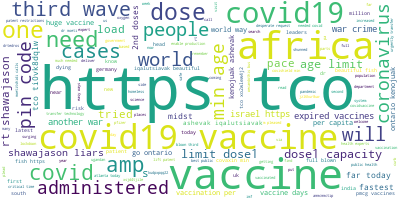

In [30]:
# Import the wordcloud library

from wordcloud import WordCloud

# Join the different processed titles together.

long_string = ','.join(list(papers['paper_text_processed'].values))

# Create a WordCloud object

wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')

# Generate a word cloud

wordcloud.generate(long_string)

# Visualize the word cloud

wordcloud.to_image()

# Step 4 Prepare data for LDA Analysis

Next, let’s work to transform the textual data in a format that will serve as an input for training LDA model. We start by tokenizing the text and removing stopwords. Next, we convert the tokenized object into a corpus and dictionary.

In [31]:
import gensim
from gensim.utils import simple_preprocess
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in stop_words] for doc in texts]


data = papers.paper_text_processed.values.tolist()
data_words = list(sent_to_words(data))

# remove stop words
data_words = remove_stopwords(data_words)

print(data_words[:1][0][:30])


['dr', 'moeti', 'head', 'africa', 'one', 'best', 'public', 'health', 'experts', 'leaders', 'know', 'desperate', 'request', 'vaccines', 'africa', 'plead', 'germany', 'uk', 'lift', 'patent', 'restrictions', 'urgently', 'transfer', 'technology', 'enable', 'production', 'africa']


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/eyerusalem/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [32]:
import gensim.corpora as corpora

# Create Dictionary
id2word = corpora.Dictionary(data_words)

# Create Corpus
texts = data_words

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1][0][:30])

[(0, 3), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1)]


# Step 5: LDA model tranining 

keeping all the parameters to default except for inputting the number of topics, its time to build a model with 10 topics where each topic is a combination of keywords, and each keyword contributes a certain weightage to the topic. 

In [33]:
from pprint import pprint

# number of topics
num_topics = 10

# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)

# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.028*"tco" + 0.027*"https" + 0.015*"one" + 0.014*"vaccines" + 0.014*"rt" + '
  '0.013*"covid" + 0.013*"vaccine" + 0.010*"ontario" + 0.008*"cinnagender" + '
  '0.008*"njvfplcyov"'),
 (1,
  '0.049*"https" + 0.048*"tco" + 0.043*"covid" + 0.027*"vaccines" + '
  '0.013*"africa" + 0.012*"people" + 0.008*"south" + 0.008*"risk" + '
  '0.008*"coronavirus" + 0.008*"vaccine"'),
 (2,
  '0.044*"tco" + 0.042*"https" + 0.037*"vaccines" + 0.026*"covid" + '
  '0.023*"africa" + 0.015*"vaccine" + 0.010*"doses" + 0.010*"dr" + 0.009*"amp" '
  '+ 0.009*"third"'),
 (3,
  '0.025*"tco" + 0.023*"https" + 0.019*"vaccines" + 0.019*"covid" + '
  '0.016*"world" + 0.013*"ontario" + 0.013*"vaccine" + 0.011*"go" + '
  '0.010*"science" + 0.010*"saying"'),
 (4,
  '0.022*"covid" + 0.021*"world" + 0.019*"vaccines" + 0.013*"one" + '
  '0.013*"amp" + 0.012*"full" + 0.011*"un" + 0.011*"mask" + 0.011*"lockdowns" '
  '+ 0.011*"mandates"'),
 (5,
  '0.042*"tco" + 0.042*"https" + 0.013*"africa" + 0.013*"coronavirus" + '


# Step 6: Analyzing our LDA model 

Now that we have a trained model let’s visualize the topics for interpretability. To do so, we’ll use a popular visualization package, pyLDAvis which is designed to help interactively with:

 1) Better understanding and interpreting individual topics, and       
 2) Better understanding the relationships between the topics.

In [34]:
import pyLDAvis.gensim_models as gensimvis
import pickle 
import pyLDAvis
# Visualize the topics
pyLDAvis.enable_notebook()

LDAvis_prepared = gensimvis.prepare(lda_model, corpus, id2word)
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.040593  0.157471       1        1  27.118082
1     -0.086006 -0.046012       2        1  18.083294
9      0.146869 -0.010016       3        1  12.788007
8      0.107061  0.060288       4        1  11.808983
6     -0.093097  0.002514       5        1   7.353091
5     -0.084383  0.010405       6        1   6.755401
7     -0.056345 -0.001332       7        1   6.496244
3      0.088163 -0.054784       8        1   4.870683
4     -0.033287 -0.111147       9        1   3.525382
0      0.051619 -0.007388      10        1   1.200832, topic_info=         Term       Freq      Total Category  logprob  loglift
35        tco  76.000000  76.000000  Default  30.0000  30.0000
29      https  76.000000  76.000000  Default  29.0000  29.0000
0      africa  28.000000  28.000000  Default  28.0000  28.0000
113     world  11.000000  11.000000  Default  27.0000  27.0000
13        one  10.000000  10.000000  Default  26.0000  26.0000
..        ...        ...        ...      ...      ...      ...
25    another   0.175644   7.182152  Topic10  -4.9880   0.7113
28    expired   0.177237   7.434879  Topic10  -4.9790   0.6857
24   vaccines   0.362344  58.817708  Topic10  -4.2639  -0.6674
59      covid   0.340255  56.879308  Topic10  -4.3268  -0.6968
30     israel   0.174947   7.966737  Topic10  -4.9920   0.6036

[566 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
238       8  0.852248        access
374       9  0.898370       acquire
302       6  0.760543        across
127       5  0.472309        action
93        3  0.309099  administered
...     ...       ...           ...
561       2  0.644121          xsjd
231       2  0.759126            yb
761       6  0.760546     yesterday
813       3  0.708501        zambia
814       3  0.708496            zi

[655 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 10, 9, 7, 6, 8, 4, 5, 1])

# Reference
[Medium article, towards datascience](https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0)